In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Embedding, Add, Dot, Lambda, Activation, Flatten

print('Keras version: %s' % keras.__version__)

/opt/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Keras version: 2.1.5


In [3]:
PATH = 'data/ml-20m'
!ls data/ml-20m

genome-scores.csv  links.csv   ratings.csv  tags.csv
genome-tags.csv    movies.csv  README.txt


In [5]:
PATH = 'data/ml-small' #PATH = 'data/ml-20m'
!ls data/ml-small

links.csv  movies.csv  ratings.csv  README.txt	tags.csv


In [4]:
# download the MovieLens 20M dataset http://files.grouplens.org/datasets/movielens/ml-20m.zip

In [6]:
ratings_df = pd.read_csv(PATH+'/ratings.csv', dtype={'userId': int, 'movieId': int, 'rating': float})
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


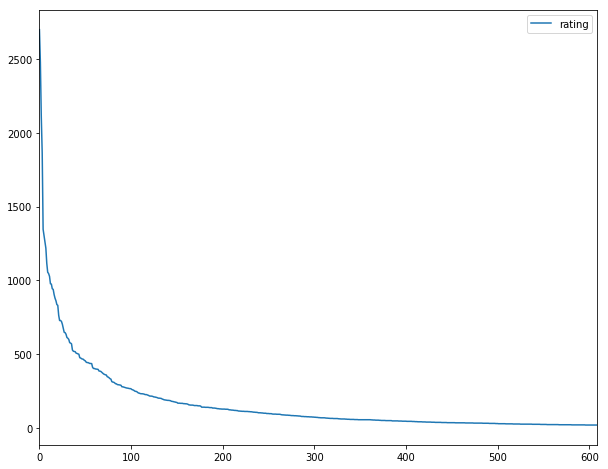

In [7]:
# Distribution of count of ratings per user
count_ratings_by_user = ratings_df.drop(axis=1, labels=['movieId', 'timestamp']).groupby('userId').count()
count_ratings_by_user = count_ratings_by_user.sort_values('rating', ascending=False).reset_index(drop=True)
count_ratings_by_user.plot(figsize=(10, 8))

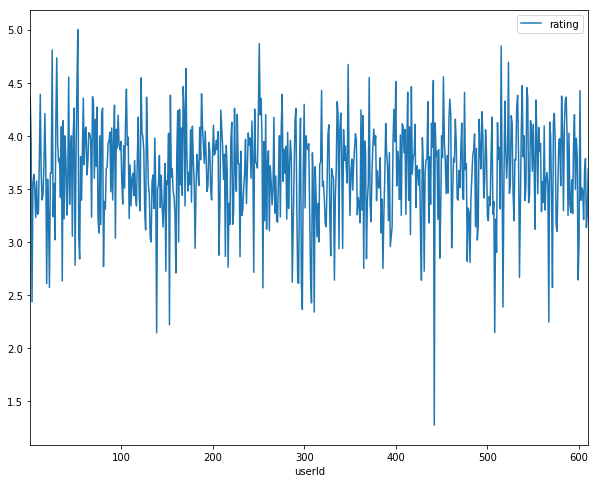

In [8]:
# Distribution of mean ratings per user
mean_ratings_by_user = ratings_df.drop(axis=1, labels=['movieId', 'timestamp']).groupby('userId').mean()
mean_ratings_by_user.plot(figsize=(10, 8))

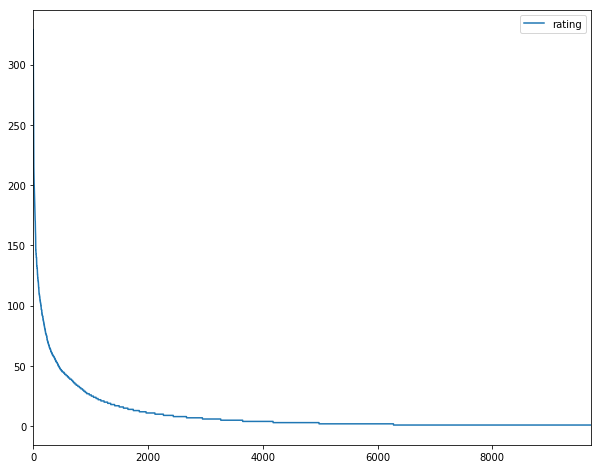

In [9]:
# Distribution of count of ratings per movie
count_ratings_by_movie = ratings_df.drop(axis=1, labels=['userId', 'timestamp']).groupby('movieId').count()
count_ratings_by_movie = count_ratings_by_movie.sort_values('rating', ascending=False).reset_index(drop=True)
count_ratings_by_movie.plot(figsize=(10, 8))

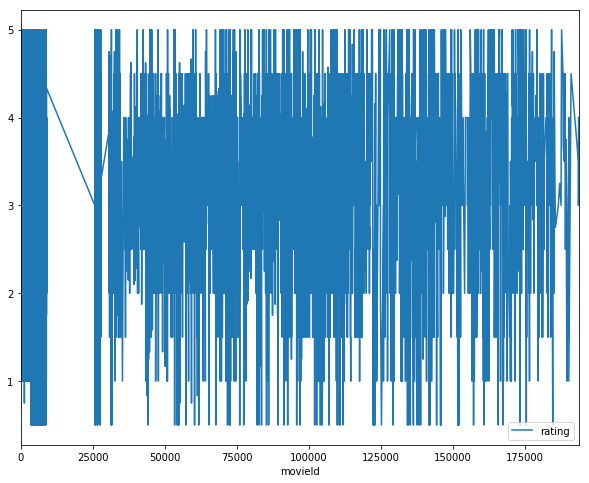

In [10]:
# Distribution of mean ratings per movie
mean_ratings_by_movie = ratings_df.drop(axis=1, labels=['userId', 'timestamp']).groupby('movieId').mean()
mean_ratings_by_movie.plot(figsize=(10, 8))

In [11]:
# Base model for callaborative filtering.
# from this we will be constructing a user-item matrix, in a every cell (i, j) we will have the rating of user i on the movie j
# we can try to learn this matrix with embeddings (i.e. a matrix of weights) for users and items, the dot product should give the rating matrix
# when defining the embeddings, e.g. user_embed: the number of words in vocab is the number of users we have, and the number of factors represent the dimensional embeddings
# we should also try to learn bias by user and by movie (there are movies that too many people would like or hate), and there are users who likes (or hates) every movie
# then then we apply a sigmoid function to get a probability (a value between 0 and 1), which later we can scale to the appropriate ratings as follows and get the predicted ratings:
# the loss function is simply an rmse, and gradient descent (or similar) algo can be used to find optimal weights.

In [12]:
matrix = ratings_df.iloc[:,:3].values
matrix.shape

(100836, 3)

In [13]:
users   = matrix[:,0] # ratings_df['userId']
items   = matrix[:,1] # ratings_df['movieId']
ratings = matrix[:,2] # ratings_df['rating']

users.shape, items.shape, ratings.shape

((100836,), (100836,), (100836,))

In [14]:
num_users = ratings_df['userId'].max()
num_items = ratings_df['movieId'].max()
max_score = ratings_df['rating'].max()
min_score = ratings_df['rating'].min()

print('Max number of users: %d' % num_users)
print('Max number of items: %d' % num_items)
print('Max rating         : %d' % max_score)
print('Min rating         : %d' % min_score)

Max number of users: 610
Max number of items: 193609
Max rating         : 5
Min rating         : 0


In [18]:
testset_size = int(matrix.shape[0] * 0.05)
trainset_size = matrix.shape[0] - testset_size

users_train, items_train, ratings_train = users[:trainset_size], items[:trainset_size], ratings[:trainset_size]
users_test, items_test, ratings_test = users[trainset_size:], items[trainset_size:], ratings[trainset_size:]

In [19]:
num_factors = 20 # embedding dimentionality 

# input
users_input = Input(shape=(1,))
items_input = Input(shape=(1,))

# embedding
user_weight = Embedding(num_users, num_factors, input_length=1)(users_input)
item_weight = Embedding(num_items, num_factors, input_length=1)(items_input)

# bias
user_bias = Embedding(num_users, 1, input_length=1)(users_input)
item_bias = Embedding(num_items, 1, input_length=1)(items_input)

# the collaborative filtering logic
res1 = Dot(axes=-1)([user_weight, item_weight]) # multiply users weights by items weights
res2 = Add()([res1, user_bias])       # add user bias
res3 = Add()([res2, item_bias])       # add item bias
res4 = Flatten()(res3)
res5 = Activation('sigmoid')(res4)    # apply sigmoid to get probabilities
# scale the probabilities to make them ratings
ratings_output = Lambda(lambda x: x * (max_score - min_score) + min_score)(res5)

model = Model(inputs=[users_input, items_input], outputs=[ratings_output])

In [20]:
# compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 20)        12200       input_3[0][0]                    
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 1, 20)        3872180     input_4[0][0]                    
__________________________________________________________________________________________________
dot_2 (Dot

In [21]:
epochs                 = 10
batch_size             = 1024

# train model
history = model.fit(
    x                = [users_train, items_train],
    y                = ratings_train,
    epochs           = epochs,
    batch_size       = batch_size,
    validation_split = 0.2,
    verbose          = 1
)

Train on 76636 samples, validate on 19159 samples
Epoch 1/10
76636/76636 [==============================] - 3s 42us/step - loss: 1.5938 - acc: 0.2011 - val_loss: 1.5597 - val_acc: 0.1874
Epoch 2/10
76636/76636 [==============================] - 0s 4us/step - loss: 1.4387 - acc: 0.2011 - val_loss: 1.5099 - val_acc: 0.1874
Epoch 3/10
76636/76636 [==============================] - 0s 4us/step - loss: 1.2572 - acc: 0.2011 - val_loss: 1.4665 - val_acc: 0.1874
Epoch 4/10
76636/76636 [==============================] - 0s 4us/step - loss: 1.0275 - acc: 0.2186 - val_loss: 1.4349 - val_acc: 0.1878
Epoch 5/10
76636/76636 [==============================] - 0s 4us/step - loss: 0.8443 - acc: 0.2761 - val_loss: 1.4171 - val_acc: 0.1888
Epoch 6/10
76636/76636 [==============================] - 0s 4us/step - loss: 0.7397 - acc: 0.3092 - val_loss: 1.4077 - val_acc: 0.1893
Epoch 7/10
76636/76636 [==============================] - 0s 4us/step - loss: 0.6762 - acc: 0.3319 - val_loss: 1.4029 - val_acc: 0.18

In [22]:
# summarize history for accuracy
def plot_accuracy(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
# summarize history for loss
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

['acc', 'loss', 'val_acc', 'val_loss']


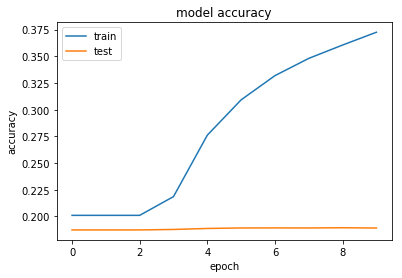

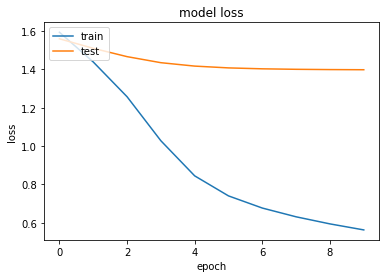

In [23]:
# list all data in history
print(history.history.keys())

plot_accuracy(history)
plot_loss(history)

In [24]:
# Predicting the Test set results
ratings_pred = model.predict([users_test, items_test])
np.sqrt(np.mean((ratings_pred-ratings_test)**2))

1.1931710314231267

In [ ]:
# Creating the Confusion Matrix
#from sklearn.metrics import confusion_matrix
#cm = confusion_matrix(ratings_test, ratings_pred, labels=[i for i in range(6)])
# it seems the confusion matrix works only for classification problems